In [865]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

# Import all common libraries for models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Import libraries related to the models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### Loading the dataset

In [866]:
# Load the input csv file
df_songs = pd.read_csv("data/song_data.csv", delimiter=",")
df_songs.reset_index(drop=True)
df_songs.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


### Data Cleanup

In [867]:
# Merge the 2 dataframes
df_merged = df_songs

# Remove the song name
df_merged.drop("song_name", axis=1, inplace=True)

# Drop NA
df_merged.dropna(inplace=True)

df_merged.reset_index(drop=True)
df_merged.shape

(18835, 14)

In [868]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.2 MB


Define the datatypes of the fields correctly (numerical and categorical)

In [869]:
# Convert song duration to numeric types
df_merged["song_duration_ms"] = df_merged["song_duration_ms"].astype("float64")

# Category type
# Key encoding
df_merged["key"] = df_merged["key"].astype("category")

# Time Signature encoding
df_merged["time_signature"] = df_merged["time_signature"].astype("category")

# Audio Mode encoding
df_merged["audio_mode"] = df_merged["audio_mode"].astype("category")

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   song_popularity   18835 non-null  int64   
 1   song_duration_ms  18835 non-null  float64 
 2   acousticness      18835 non-null  float64 
 3   danceability      18835 non-null  float64 
 4   energy            18835 non-null  float64 
 5   instrumentalness  18835 non-null  float64 
 6   key               18835 non-null  category
 7   liveness          18835 non-null  float64 
 8   loudness          18835 non-null  float64 
 9   audio_mode        18835 non-null  category
 10  speechiness       18835 non-null  float64 
 11  tempo             18835 non-null  float64 
 12  time_signature    18835 non-null  category
 13  audio_valence     18835 non-null  float64 
dtypes: category(3), float64(10), int64(1)
memory usage: 1.8 MB


Remove the rows with popularity score, instrumentalness, tempo and time_signature = 0

In [870]:
# Remove the songs with popularity=0. This is due to spotify's internal algorithm and also the time when the data was extracted (a song could have just been released)
df_merged = df_merged[df_merged['song_popularity']>0]

# Remove songs that have instrumentalness and tempo as 0
df_merged = df_merged[(df_merged['instrumentalness']>0) & (df_merged['tempo']>0)]

# Drop the solo entry with time signature = 0
df_merged.drop(df_merged[df_merged['time_signature']==0].index, inplace=True)


### Classify top 30% songs as popular

In [871]:
# Classify top 30% songs as popular
df_temp = df_merged.sort_values('song_popularity',ascending=False).head(int(df_merged.shape[0]*.3))

# Take the last value
popularity_threshold = df_temp['song_popularity'].tail(1).values[0]
print("Popularity score threshold : ",popularity_threshold)

# df_temp['song_popularity'].tail(1) returns a numpy.series
# .values will then convert a series into array

Popularity score threshold :  63


In [872]:
# Assign popular=1 for songs that have a popularity score of >= 60. Else 0
df_merged['is_popular'] = np.where(df_merged['song_popularity']>=popularity_threshold, 1, 0)

df_merged.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,is_popular
0,73,262333.0,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474,1
2,76,231733.0,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324,1
3,74,216933.0,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198,1
5,80,235893.0,0.008950,0.316,0.945,0.000002,4,0.3960,-3.169,0,0.1240,189.931,4,0.320,1
6,81,199893.0,0.000504,0.581,0.887,0.001110,4,0.2680,-3.659,0,0.0624,90.578,4,0.724,1


## Handling Outliers

In [873]:
df_merged.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,is_popular
count,11502.000000,1.150200e+04,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000
mean,51.185359,2.223621e+05,0.270938,0.619752,0.635275,0.124624,0.174285,-8.083589,0.083544,120.791379,0.511950,0.312467
std,20.370106,6.584289e+04,0.311289,0.162325,0.231709,0.269480,0.140464,4.292172,0.084540,28.384838,0.255141,0.463519
min,1.000000,2.618600e+04,0.000001,0.059400,0.001070,0.000001,0.010900,-38.768000,0.022400,46.591000,0.023000,0.000000
25%,40.000000,1.861762e+05,0.015300,0.516000,0.482250,0.000022,0.091700,-9.905500,0.036400,99.076000,0.303000,0.000000
50%,54.000000,2.137195e+05,0.124000,0.632000,0.670000,0.000635,0.119000,-7.113000,0.050000,120.014000,0.507000,0.000000
75%,66.000000,2.493345e+05,0.477000,0.741000,0.823000,0.037700,0.209750,-5.179000,0.089400,138.028000,0.721000,1.000000
max,98.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,0.986000,1.585000,0.915000,242.318000,0.982000,1.000000


Key observations:
  - song_duration_ms appears to be the only column where the max value seems significantly higher. It is worth checking outliers in the song duration.
  - instrumentalness has standard deviation that is nearly 2.2 times the mean value. This could be due to a significant number of songs being very high on vocal (rap, hip hop, etc) or purely instrumental. They might not be outliers as this could be a valid son composition.

Identify outliers in song duration column using the z-scores in the dataset and taking 3 as the threshold for removing any outliers.

In [874]:
# Check for outliers in song duration. All other columns seem to be in a decent range
df_merged["zscore"] = np.abs(zscore(df_merged['song_duration_ms']))
print(f'Original shape: {df_merged.shape}')

# Filter out the values with z score higher than 3
df_merged = df_merged[(df_merged.zscore>-3) & (df_merged.zscore<3)]
print(f'Shape after removing outliers in song duration : {df_merged.shape}')

df_merged["zscore"] = np.abs(zscore(df_merged['instrumentalness']))
df_merged = df_merged[(df_merged.zscore>-3) & (df_merged.zscore<3)]
print(f'Shape after removing outliers in instrumentalness: {df_merged.shape}')

# drop z-values
df_merged.drop("zscore", axis=1, inplace=True)
df_merged.head()

Original shape: (11502, 16)
Shape after removing outliers in song duration : (11366, 16)
Shape after removing outliers in instrumentalness: (11123, 16)


,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,is_popular
0,73,262333.0,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474,1
2,76,231733.0,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324,1
3,74,216933.0,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198,1
5,80,235893.0,0.008950,0.316,0.945,0.000002,4,0.3960,-3.169,0,0.1240,189.931,4,0.320,1
6,81,199893.0,0.000504,0.581,0.887,0.001110,4,0.2680,-3.659,0,0.0624,90.578,4,0.724,1


In [875]:
df_merged.reset_index(drop=True) # This statement resets the index and removes the rows with NaN values. This can be handled in several other ways, which are no included in scope for this notebook
df_merged.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,is_popular
count,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000
mean,51.263418,219788.740448,0.260371,0.623019,0.643437,0.104359,0.174700,-7.841723,0.083763,121.111204,0.517071,0.316641
std,20.495192,53166.997108,0.301847,0.159976,0.223871,0.240451,0.140192,3.898300,0.084338,28.207594,0.253418,0.465187
min,1.000000,50508.000000,0.000001,0.059400,0.001630,0.000001,0.011900,-36.729000,0.022400,46.591000,0.023000,0.000000
25%,40.000000,187019.500000,0.014900,0.521000,0.493000,0.000021,0.091650,-9.685000,0.036300,99.808500,0.310500,0.000000
50%,54.000000,213626.000000,0.117000,0.634000,0.675000,0.000522,0.119000,-7.024000,0.049900,120.026000,0.511000,0.000000
75%,66.000000,248024.000000,0.450000,0.742000,0.825000,0.026100,0.213000,-5.128000,0.090100,138.161000,0.724500,1.000000
max,98.000000,419500.000000,0.996000,0.987000,0.999000,0.924000,0.986000,1.585000,0.915000,242.318000,0.982000,1.000000


### Scaling the dataset

In [876]:
# Divide the dataset into input and output
df_merged.reset_index(drop=True)
#X = df_merged.drop("is_popular", axis=1)
X = df_merged
y = df_merged.is_popular

# Normalise the numerical columns in the dataset
numerical = ["song_duration_ms","acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","audio_valence"]
print(numerical)
scaler = MinMaxScaler()
X[numerical] = scaler.fit_transform(X[numerical])

# Round all values to 6 decimals places
X[numerical].round(6)

# Print X
X.head()

['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']


,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,is_popular
0,73,0.574064,0.005541,0.470677,0.682164,3.073596e-05,8,0.048250,0.851751,1,0.007842,0.615495,4,0.470282,1
2,76,0.491135,0.008201,0.730487,0.462587,4.837657e-01,0,0.249564,0.754320,1,0.063634,0.394887,4,0.313869,1
3,74,0.451026,0.026505,0.422165,0.970924,3.840913e-03,0,0.092496,0.829749,1,0.094779,0.387545,4,0.182482,1
5,80,0.502409,0.008985,0.276628,0.945858,9.199144e-07,4,0.394313,0.875920,0,0.113825,0.732347,4,0.309698,1
6,81,0.404846,0.000505,0.562311,0.887705,1.200218e-03,4,0.262909,0.863131,0,0.044813,0.224736,4,0.730970,1


### Encode the Categorical variables

Categorical encoding is used to encode the categorical variables - 'key', 'audio_mode', and 'time_signature'.

In [877]:
# Encode categorical variables with Category encode
categorical = ["key", "time_signature", "audio_mode"]

for item in categorical:
    # X[item] = X[item].astype("category").cat.codes
    X[item] = X[item].astype("category").cat.codes

X.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,is_popular
0,73,0.574064,0.005541,0.470677,0.682164,3.073596e-05,8,0.048250,0.851751,1,0.007842,0.615495,3,0.470282,1
2,76,0.491135,0.008201,0.730487,0.462587,4.837657e-01,0,0.249564,0.754320,1,0.063634,0.394887,3,0.313869,1
3,74,0.451026,0.026505,0.422165,0.970924,3.840913e-03,0,0.092496,0.829749,1,0.094779,0.387545,3,0.182482,1
5,80,0.502409,0.008985,0.276628,0.945858,9.199144e-07,4,0.394313,0.875920,0,0.113825,0.732347,3,0.309698,1
6,81,0.404846,0.000505,0.562311,0.887705,1.200218e-03,4,0.262909,0.863131,0,0.044813,0.224736,3,0.730970,1


In [878]:
X.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,is_popular
count,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000
mean,51.263418,0.458765,0.261416,0.607610,0.643499,0.112942,5.293536,0.167128,0.753961,0.633282,0.068746,0.380735,2.955947,0.515193,0.316641
std,20.495192,0.144087,0.303060,0.172462,0.224461,0.260229,3.595270,0.143920,0.101746,0.481930,0.094486,0.144117,0.266585,0.264252,0.465187
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,40.000000,0.369958,0.014958,0.497628,0.492666,0.000021,2.000000,0.081870,0.705852,0.000000,0.015572,0.271897,3.000000,0.299791,0.000000
50%,54.000000,0.442064,0.117469,0.619448,0.675146,0.000564,6.000000,0.109948,0.775304,1.000000,0.030809,0.375191,3.000000,0.508863,0.000000
75%,66.000000,0.535285,0.451806,0.735878,0.825541,0.028246,8.000000,0.206447,0.824790,1.000000,0.075846,0.467846,3.000000,0.731491,1.000000
max,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


## Exploratory Data Analysis (EDA)

#### Part 1 - Numerical Fields


EDA 1.1 - Correlation between numerical fields

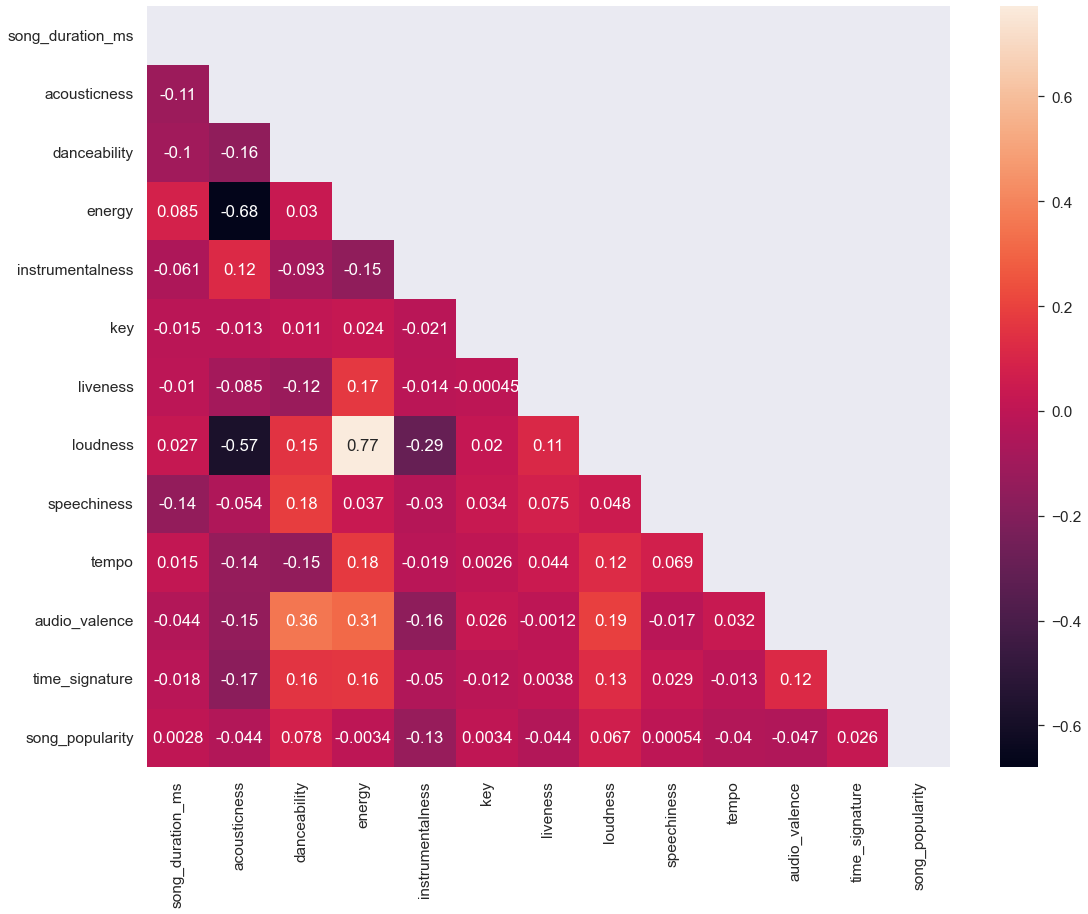

In [879]:
numerical_with_output = ["song_duration_ms","acousticness","danceability","energy", "instrumentalness", "key", "liveness","loudness","speechiness","tempo","audio_valence", "time_signature", "song_popularity"]

matrix = np.triu(df_merged[numerical_with_output].corr())
fig, ax = plt.subplots(figsize=(18,14))
sns.set(font_scale=1.4)
sns.heatmap(df_merged[numerical_with_output].corr(), annot=True, ax=ax, mask=matrix);

EDA 1.2 - Histograms for popular songs

Observations:
  - Data suggests that people tend to prefer songs that are louder, with beats and vocals, and are dance numbers with high energy.
  - danceability, energy, loudness are all left skewed. This is intuitive too as these are typically the fast paced, high energy dance numbers
  - accousticness and instrumentalness are highly right skewed, implying that majority of the songs are not acoustic (have multiple instruments, beats) and have vocals

array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

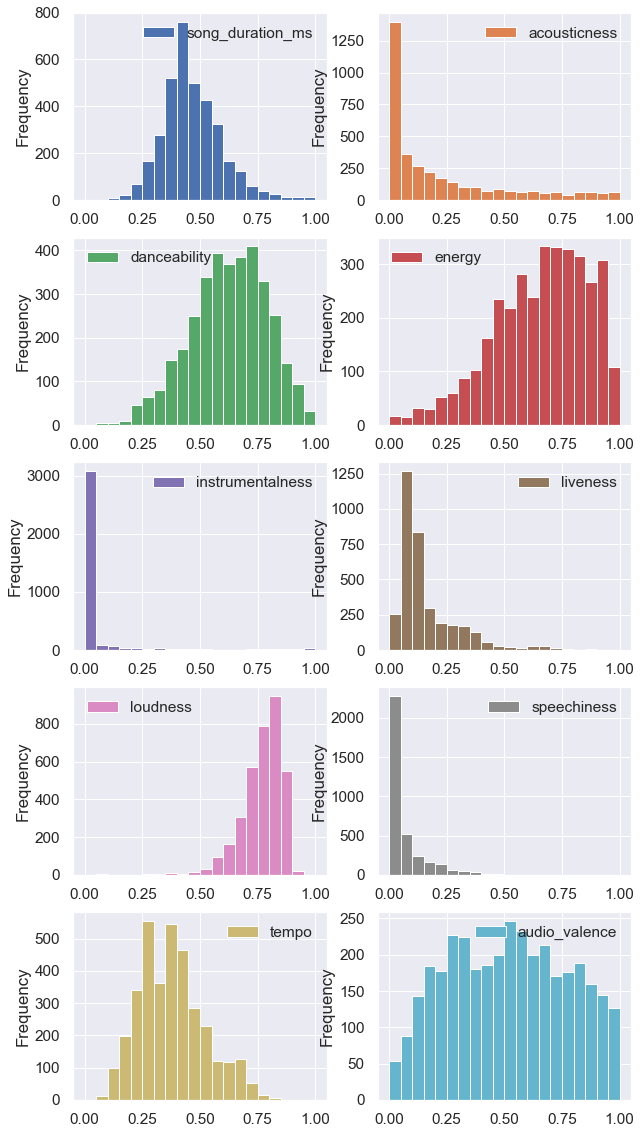

In [880]:
# Plot all the numerical columns as histograms
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,20))
sns.set(font_scale=1.4)
X_popular = X[X['is_popular']==1]
X_popular[numerical].plot.hist(subplots=True, legend=True, layout=(5, 2), bins=20, ax=ax)

EDA 1.3 - Histograms for songs that are not popular

array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

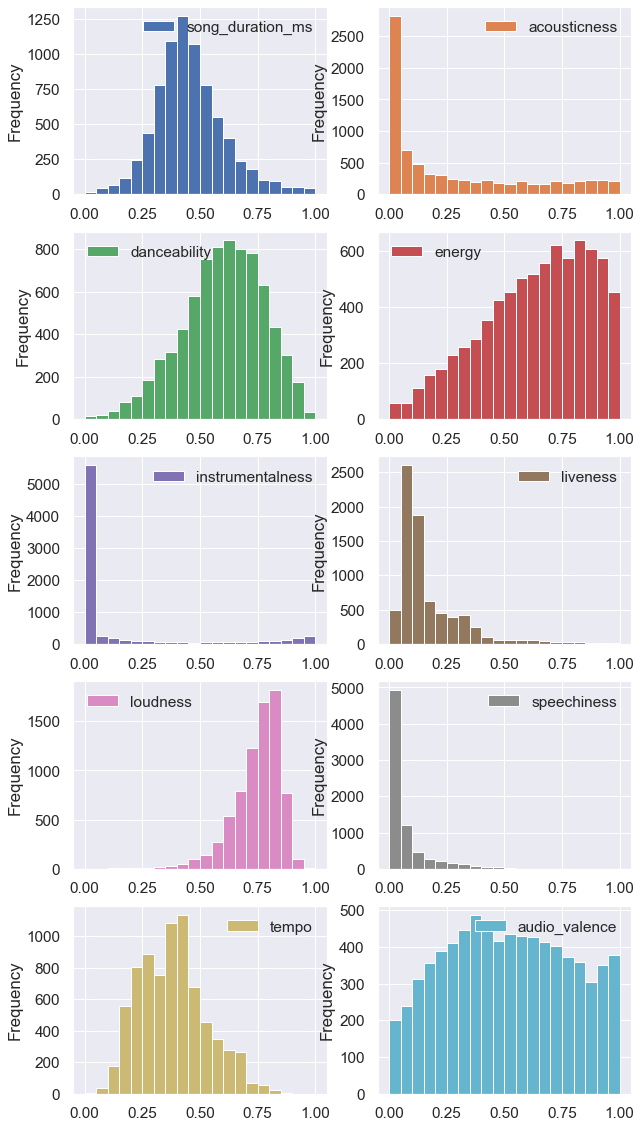

In [881]:
# Plot all the numerical columns as histograms
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,20))
sns.set(font_scale=1.4)
X_not_popular = X[X['is_popular']==0]
X_not_popular[numerical].plot.hist(subplots=True, legend=True, layout=(5, 2), bins=20, ax=ax)

EDA 1.3 - Loudness and Popularity

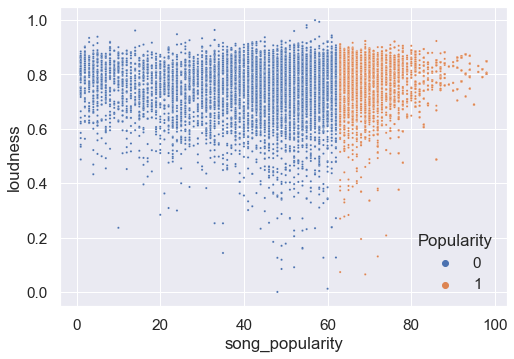

In [882]:
sns.scatterplot(data=df_merged, x='song_popularity', y='loudness', hue='is_popular', s=5)
plt.legend(loc='lower right', title='Popularity')
plt.show()

In [886]:
loudness_all = round(df_merged['loudness'].mean(), 4)
loudness_pop = round(df_merged[df_merged['is_popular']==1]['loudness'].mean(), 4)
loudness_unpop = round(df_merged[df_merged['is_popular']==0]['loudness'].mean(), 4)
print("Mean loudness of all songs: ", loudness_all)
print("Mean loudness of popular songs: ", loudness_pop)
print("Mean loudness of songs not popular: ", loudness_unpop)

Mean loudness of all songs:  0.754
Mean loudness of popular songs:  0.7687
Mean loudness of songs not popular:  0.7472


EDA 1.4 - Energy and Popularity

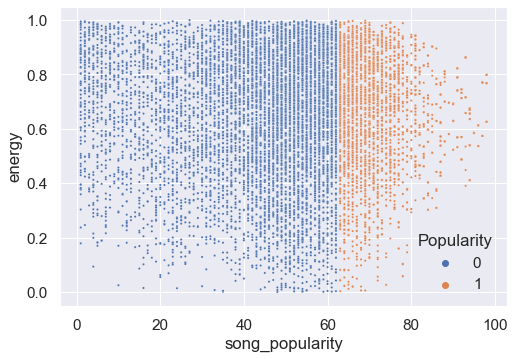

In [883]:
sns.scatterplot(data=df_merged, x='song_popularity', y='energy', hue='is_popular', s=5)
plt.legend(loc='lower right', title='Popularity')
plt.show()

In [887]:
energy_all = round(df_merged['energy'].mean(), 4)
energy_pop = round(df_merged[df_merged['is_popular']==1]['energy'].mean(), 4)
energy_unpop = round(df_merged[df_merged['is_popular']==0]['energy'].mean(), 4)
print("Mean energy of all songs: ", energy_all)
print("Mean energy of popular songs: ", energy_pop)
print("Mean energy of songs not popular: ", energy_unpop)

Mean energy of all songs:  0.6435
Mean energy of popular songs:  0.6573
Mean energy of songs not popular:  0.6371


EDA 1.5 - Danceability and Popularity

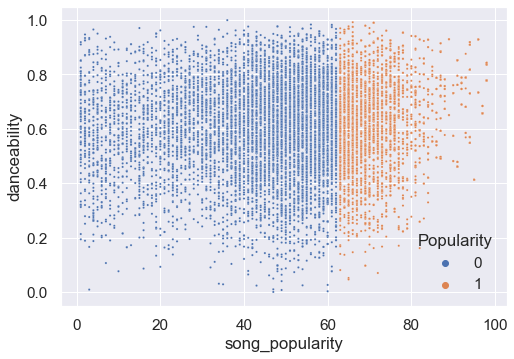

In [884]:
sns.scatterplot(data=df_merged, x='song_popularity', y='danceability', hue='is_popular', s=5)
plt.legend(loc='lower right', title='Popularity')
plt.show()

In [888]:
danceability_all = round(df_merged['energy'].mean(), 4)
danceability_pop = round(df_merged[df_merged['is_popular']==1]['energy'].mean(), 4)
danceability_unpop = round(df_merged[df_merged['is_popular']==0]['energy'].mean(), 4)
print("Mean danceability of all songs: ", danceability_all)
print("Mean danceability of popular songs: ", danceability_pop)
print("Mean danceability of songs not popular: ", danceability_unpop)

Mean danceability of all songs:  0.6435
Mean danceability of popular songs:  0.6573
Mean danceability of songs not popular:  0.6371


EDA 1.6 - Pairplot with all features

In [838]:
#sns.pairplot(df_merged[numerical_with_output], plot_kws={"s": 5})

Observations:
  - Linear models might not be ideal for modeling as there does not seem to be any linear relationships between variables and the song popularity score

### Part 2 - Categorical Fields

EDA 2.1 - Distribution of songs by keys

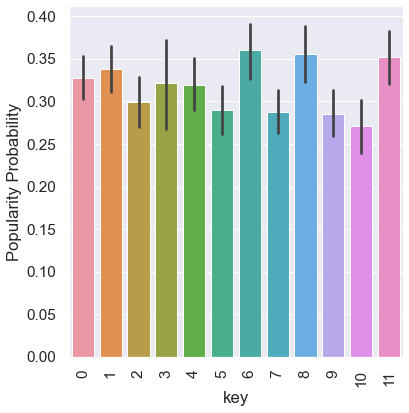

In [839]:
g = sns.catplot(x = "key", y = "is_popular", data = df_merged, kind = "bar", height = 6)
g.set_ylabels("Popularity Probability")
plt.xticks(rotation=90)
plt.show()

Songs with keys 6, 8, 11 have higher probability of becoming popular

EDA 2.2 - Distribution of songs by time_signature

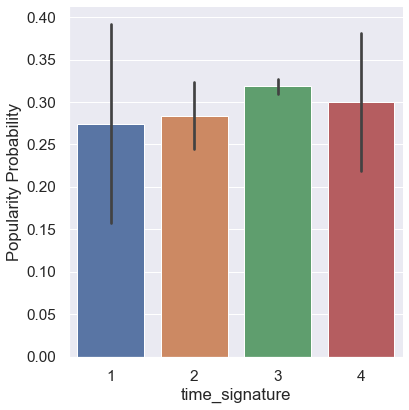

In [840]:
g = sns.catplot(x = "time_signature", y = "is_popular", data = df_merged, kind = "bar", height = 6)
g.set_ylabels("Popularity Probability")
plt.show()

EDA 2.3 - Distribution of songs by audio mode

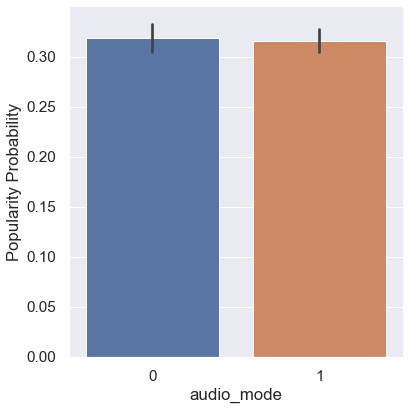

In [889]:
g = sns.catplot(x = "audio_mode", y = "is_popular", data = df_merged, kind = "bar", height = 6)
g.set_ylabels("Popularity Probability")
plt.show()

## Split into training and testing sets

In [841]:
# Drop Song Popularity column as the output is now a binary class 'is_popular'
X.drop(['song_popularity', 'is_popular'], axis=1, inplace=True)

In [842]:
random_state=42

# Divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

X_train.head()

X_train:  (7786, 13)
X_test:  (3337, 13)
y_train:  (7786,)
y_test:  (3337,)


,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
10623,0.374938,0.460843,0.927771,0.647072,0.009252,0,0.066420,0.735397,1,0.108223,0.298477,3,0.246090
5442,0.365460,0.565260,0.858775,0.516729,0.000176,6,0.135612,0.717675,0,0.007730,0.366878,3,0.475495
5644,0.380203,0.766064,0.439414,0.618998,0.005897,5,0.173596,0.695568,1,0.015124,0.662683,3,0.837331
10297,0.511914,0.135541,0.819966,0.937837,0.000137,5,0.347090,0.833090,0,0.036635,0.431223,3,0.920751
15359,0.643515,0.322288,0.511643,0.854618,0.000050,8,0.082846,0.821919,1,0.048734,0.236789,3,0.767466


## Handling imbalance in the dataset using SMOTE

In [843]:
# Before SMOTE
y_train.value_counts()

0    5321
1    2465
Name: is_popular, dtype: int64

In [844]:
#X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
smote = SMOTE(sampling_strategy='minority', random_state=random_state)

# Get indices of the categorical features
#categorical_features_indices = np.where(X.dtypes == 'int64')[0]
#categorical_features_indices = []
#for col in categorical:
#    categorical_features_indices.append(X_train.columns.get_loc(col))

# Use SMOTENC since it handles sampling of categorical feautures
#smote = SMOTENC(categorical_features=categorical_features_indices, random_state=random_state)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train.value_counts()

0    5321
1    5321
Name: is_popular, dtype: int64

## Functions for the models

In [845]:
# Assign the model to the model name
def assign_model(model_name, k):
    if model_name == "Logistic Regression":
        model = LogisticRegression(solver='liblinear')

    elif model_name == "SVM":
        model = SVC(gamma='scale', probability=True)

    elif model_name == "K-Nearest Neighbors":
        model = KNeighborsClassifier(n_neighbors=k)

    elif model_name == "Naive Bayes":
        model = GaussianNB()

    elif model_name == "Ada Boost":
        model = AdaBoostClassifier(random_state=random_state)

    elif model_name == "Random Forest":
        model = RandomForestClassifier(random_state=random_state)

    elif model_name == "Gradient Tree Boosting":
        model = GradientBoostingClassifier(random_state=random_state)

    elif model_name == "XG Boost":
        model = XGBClassifier(random_state=random_state, nthread=4, objective='binary:logistic')

    elif model_name == "LightGBM":
        model = LGBMClassifier(random_state=random_state)

    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(random_state=random_state)
    # For each model, define the module

    return model

In [859]:
# Create model
def create_model(model_name, knn_k):
    # For each model, define the module and the parameter grid to find the best parameters
    model = assign_model(model_name, knn_k)

    # Fit the model with training data
    if model_name == "LightGBM":
        model.fit(X_train, y_train, categorical_feature=categorical)
    else:
        model.fit(X_train, y_train)

    # Predict the output on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    acc_score = round(accuracy_score(y_test, y_pred),4)

    # Calculate CV result
    cv_result = cross_val_score(model, X_train, y_train, cv=10)

    return model, acc_score, cv_result, y_pred

In [847]:
# Plot ROC Curve and return ROC score
def plot_roc_curve(model):

    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    auc_score = round(auc(fpr, tpr), 4)
    print(f'\nROC AUC: \n{auc_score}')
    model_auc_list.append(auc_score)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr,color="red")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()


In [848]:
# Create the model and print the results
def model_result(model_name, knn_k=5):
    model, acc_model, cv_result, y_pred = create_model(model_name, knn_k)

    # Get confusion matrix
    cm_model = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Get classification report
    cr_model = classification_report(y_true=y_test, y_pred=y_pred)

    # Print the model results
    print(f'\n ***** Model: {model_name} *****')
    print(f'\n ***** Model: {model} *****')
    print(f'\nModel Accuracy: \n{acc_model*100}%')
    print(f'\nCV Result: \n{cv_result}')
    print(f'\nAverage CV Score: \n{round(np.average(cv_result), 4)}')
    print('\nConfusion matrix: \n',cm_model)
    print('\nClassification report: \n',cr_model)

    sns.heatmap(cm_model,annot=True,fmt="d")
    plt.show()

    # Get ROC Score and plot the curve
    plot_roc_curve(model)

    # Add to the list
    model_names_list.append(model_name)
    model_accuracy_list.append(acc_model)
    model_cv_list.append(round(np.average(cv_result), 4))

    print("\n ***** End of model ***** \n")

In [849]:
# Create empty list to store the results
model_accuracy_list = []
model_names_list = []
model_cv_list = []
model_auc_list = []

### Model 1: Logistic Regression


 ***** Model: Logistic Regression *****

 ***** Model: LogisticRegression(solver='liblinear') *****

Model Accuracy: 
55.47%

CV Result: 
[0.60469484 0.58779343 0.57800752 0.58740602 0.6193609  0.6156015
 0.6137218  0.61654135 0.60902256 0.59398496]

Average CV Score: 
0.6026

Confusion matrix: 
 [[1072 1208]
 [ 278  779]]

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.47      0.59      2280
           1       0.39      0.74      0.51      1057

    accuracy                           0.55      3337
   macro avg       0.59      0.60      0.55      3337
weighted avg       0.67      0.55      0.57      3337



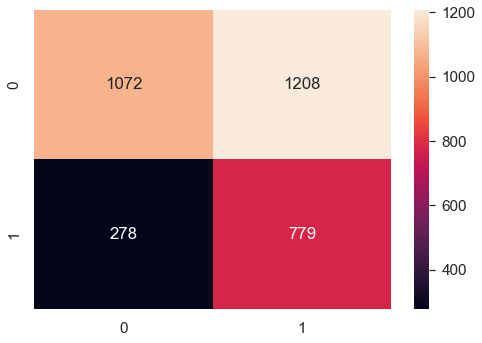


ROC AUC: 
0.6238


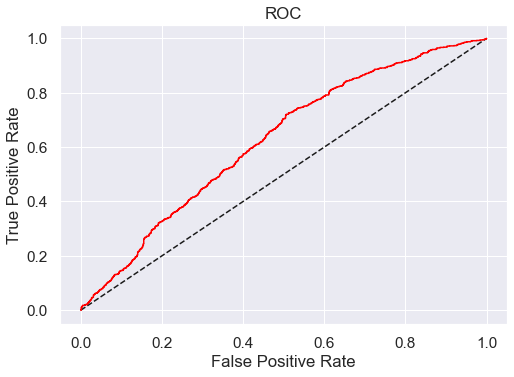


 ***** End of model ***** 



In [850]:
model_result("Logistic Regression")

### Model 2: Support Vector Machines


 ***** Model: SVM *****

 ***** Model: SVC(probability=True) *****

Model Accuracy: 
47.77%

CV Result: 
[0.57652582 0.58591549 0.56484962 0.58552632 0.58928571 0.60150376
 0.57330827 0.58552632 0.60244361 0.57706767]

Average CV Score: 
0.5842

Confusion matrix: 
 [[ 678 1602]
 [ 141  916]]

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.30      0.44      2280
           1       0.36      0.87      0.51      1057

    accuracy                           0.48      3337
   macro avg       0.60      0.58      0.48      3337
weighted avg       0.68      0.48      0.46      3337



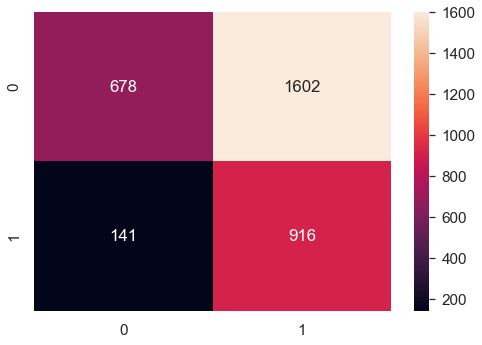


ROC AUC: 
0.6221


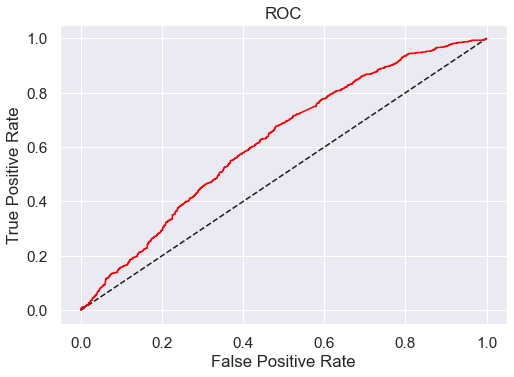


 ***** End of model ***** 



In [862]:
model_result("SVM")

### Model 3: Naive Bayes


 ***** Model: Naive Bayes *****

 ***** Model: GaussianNB() *****

Model Accuracy: 
50.43%

CV Result: 
[0.56431925 0.58215962 0.56203008 0.58082707 0.6137218  0.6212406
 0.59022556 0.62781955 0.60996241 0.60150376]

Average CV Score: 
0.5954

Confusion matrix: 
 [[ 852 1428]
 [ 226  831]]

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.37      0.51      2280
           1       0.37      0.79      0.50      1057

    accuracy                           0.50      3337
   macro avg       0.58      0.58      0.50      3337
weighted avg       0.66      0.50      0.51      3337



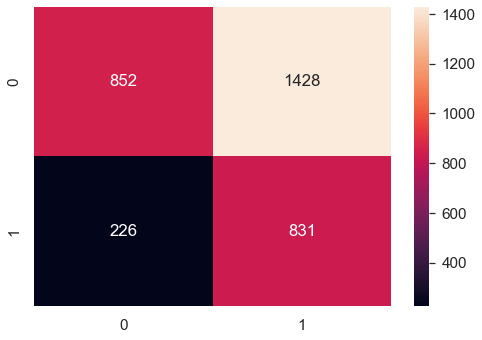


ROC AUC: 
0.6185


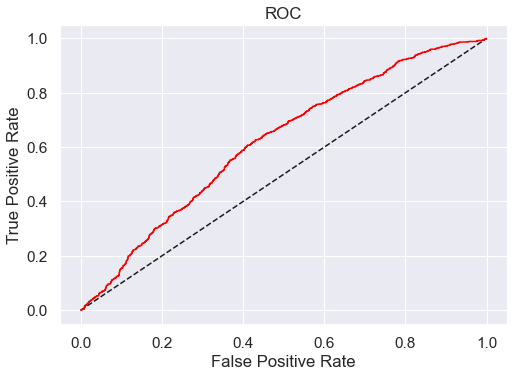


 ***** End of model ***** 



In [853]:
model_result("Naive Bayes")

### Model 4: K-Nearest Neighbors


 ***** Model: K-Nearest Neighbors *****

 ***** Model: KNeighborsClassifier() *****

Model Accuracy: 
62.660000000000004%

CV Result: 
[0.68450704 0.69014085 0.67763158 0.70582707 0.73684211 0.76221805
 0.76315789 0.7556391  0.75281955 0.7593985 ]

Average CV Score: 
0.7288

Confusion matrix: 
 [[1343  937]
 [ 309  748]]

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.59      0.68      2280
           1       0.44      0.71      0.55      1057

    accuracy                           0.63      3337
   macro avg       0.63      0.65      0.61      3337
weighted avg       0.70      0.63      0.64      3337



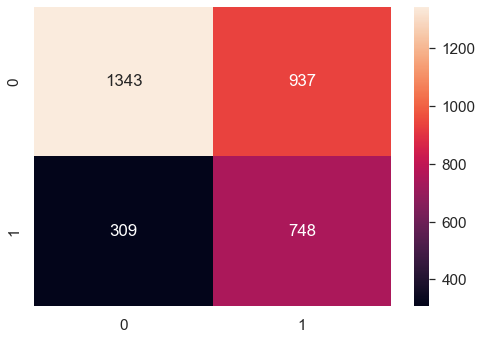


ROC AUC: 
0.7095


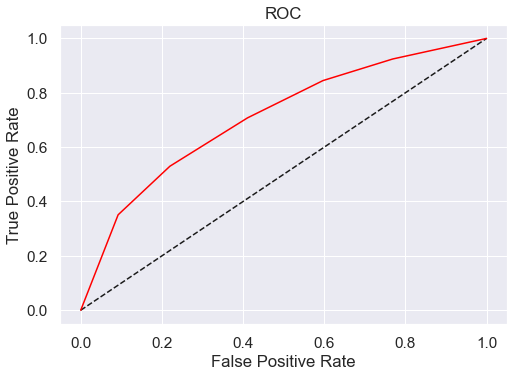


 ***** End of model ***** 



In [854]:
model_result("K-Nearest Neighbors")

### Model 5: Decision Trees


 ***** Model: Decision Tree *****

 ***** Model: DecisionTreeClassifier(random_state=42) *****

Model Accuracy: 
70.50999999999999%

CV Result: 
[0.72018779 0.74741784 0.7462406  0.73214286 0.7406015  0.77725564
 0.73120301 0.74718045 0.7537594  0.7537594 ]

Average CV Score: 
0.745

Confusion matrix: 
 [[1613  667]
 [ 317  740]]

Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      2280
           1       0.53      0.70      0.60      1057

    accuracy                           0.71      3337
   macro avg       0.68      0.70      0.68      3337
weighted avg       0.74      0.71      0.71      3337



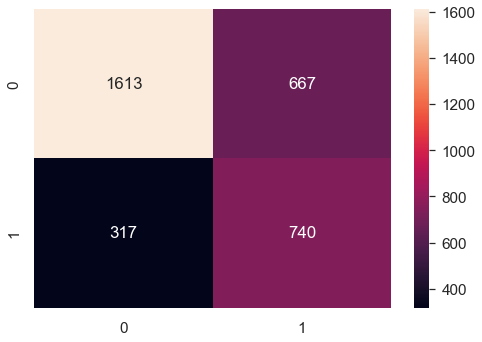


ROC AUC: 
0.7058


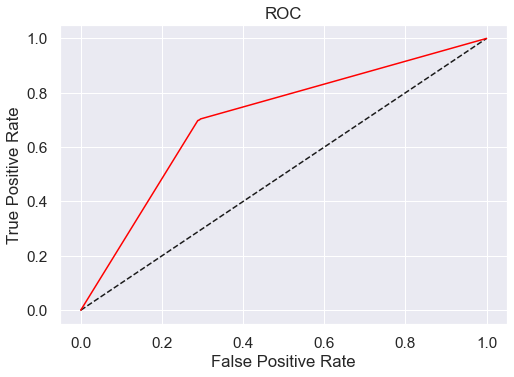


 ***** End of model ***** 



In [855]:
model_result("Decision Tree")

### Model 6: Random Forest


 ***** Model: Random Forest *****

 ***** Model: RandomForestClassifier(random_state=42) *****

Model Accuracy: 
78.03%

CV Result: 
[0.77089202 0.81220657 0.80733083 0.79041353 0.81954887 0.8693609
 0.85996241 0.87406015 0.85056391 0.86090226]

Average CV Score: 
0.8315

Confusion matrix: 
 [[1929  351]
 [ 382  675]]

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      2280
           1       0.66      0.64      0.65      1057

    accuracy                           0.78      3337
   macro avg       0.75      0.74      0.74      3337
weighted avg       0.78      0.78      0.78      3337



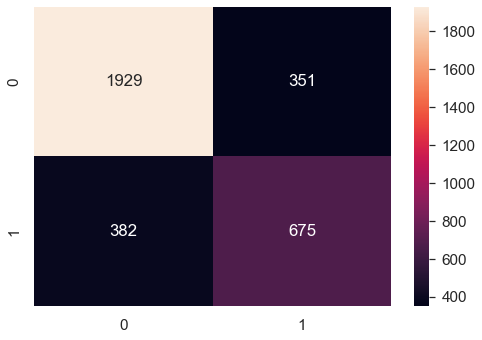


ROC AUC: 
0.8211


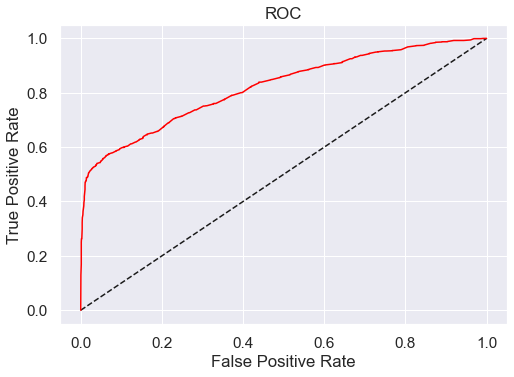


 ***** End of model ***** 



In [856]:
model_result("Random Forest")

### Model 7: XG Boost

[17:27:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

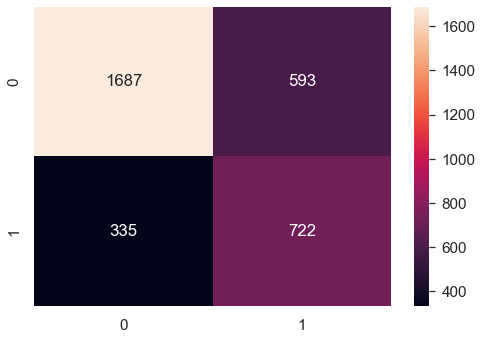


ROC AUC: 
0.7808


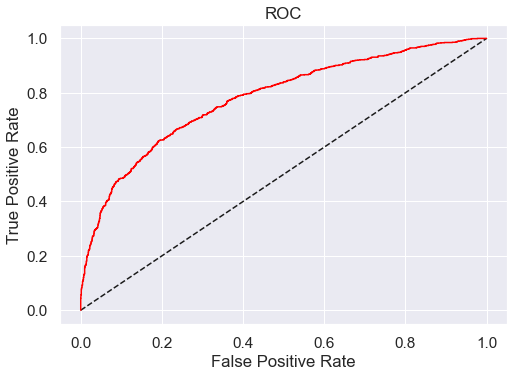


 ***** End of model ***** 



In [851]:
model_result("XG Boost")

### Model 8: AdaBoost


 ***** Model: Ada Boost *****

 ***** Model: AdaBoostClassifier(random_state=42) *****

Model Accuracy: 
57.15%

CV Result: 
[0.56807512 0.60751174 0.58176692 0.6156015  0.64379699 0.69078947
 0.68045113 0.69548872 0.63533835 0.65883459]

Average CV Score: 
0.6378

Confusion matrix: 
 [[1236 1044]
 [ 386  671]]

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.54      0.63      2280
           1       0.39      0.63      0.48      1057

    accuracy                           0.57      3337
   macro avg       0.58      0.59      0.56      3337
weighted avg       0.64      0.57      0.59      3337



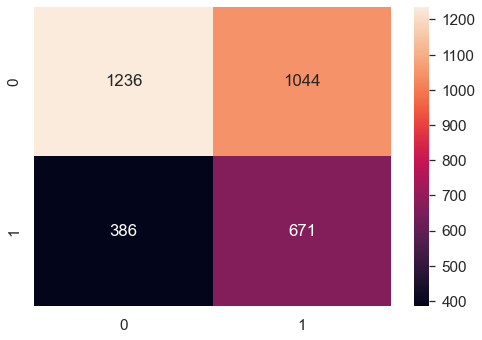


ROC AUC: 
0.6351


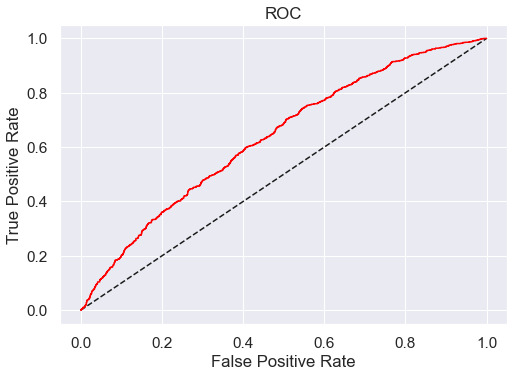


 ***** End of model ***** 



In [857]:
model_result("Ada Boost")

### Model 9: Light GBM


 ***** Model: LightGBM *****

 ***** Model: LGBMClassifier(random_state=42) *****

Model Accuracy: 
69.58%

CV Result: 
[0.68638498 0.72018779 0.70206767 0.71240602 0.72086466 0.80545113
 0.79135338 0.78947368 0.76221805 0.78853383]

Average CV Score: 
0.7479

Confusion matrix: 
 [[1661  619]
 [ 396  661]]

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      2280
           1       0.52      0.63      0.57      1057

    accuracy                           0.70      3337
   macro avg       0.66      0.68      0.67      3337
weighted avg       0.72      0.70      0.70      3337



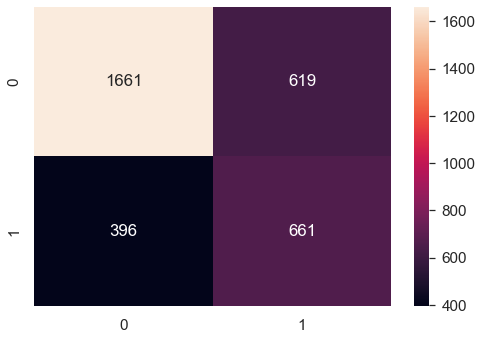


ROC AUC: 
0.7525


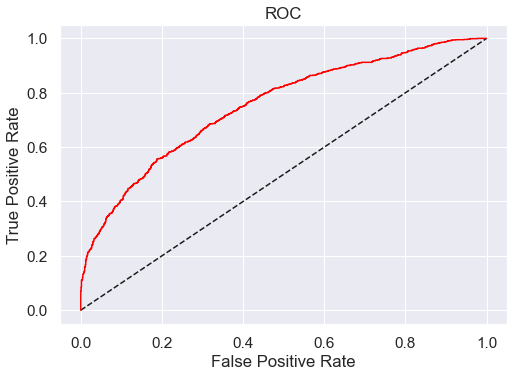


 ***** End of model ***** 



In [860]:
model_result("LightGBM")

### Model 10: Gradient Tree Boosting


 ***** Model: Gradient Tree Boosting *****

 ***** Model: GradientBoostingClassifier(random_state=42) *****

Model Accuracy: 
60.440000000000005%

CV Result: 
[0.60938967 0.63849765 0.6343985  0.64473684 0.67011278 0.73214286
 0.71616541 0.72368421 0.68045113 0.68984962]

Average CV Score: 
0.6739

Confusion matrix: 
 [[1305  975]
 [ 345  712]]

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.57      0.66      2280
           1       0.42      0.67      0.52      1057

    accuracy                           0.60      3337
   macro avg       0.61      0.62      0.59      3337
weighted avg       0.67      0.60      0.62      3337



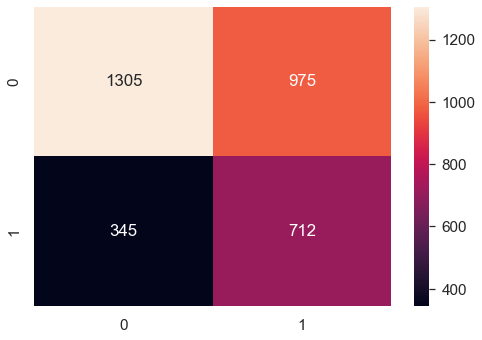


ROC AUC: 
0.6769


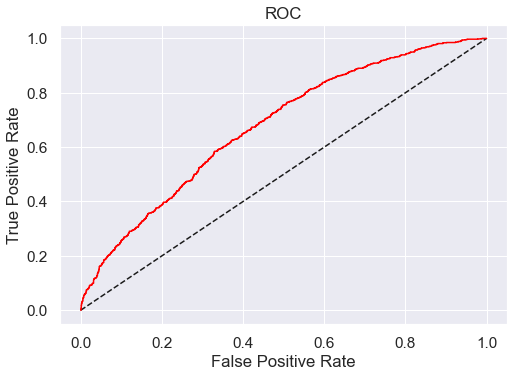


 ***** End of model ***** 



In [861]:
model_result("Gradient Tree Boosting")

## Summary of results of models with default settings

In [863]:
# Create a table of the results
df_results = pd.DataFrame({
    'Model Name': model_names_list,
    'Accuracy': model_accuracy_list,
    'CV Score': model_cv_list,
    'ROC AUC': model_auc_list
})
df_results = df_results.sort_values(by=['ROC AUC'], ascending=False)
df_results.reset_index(drop=True)

,Model Name,Accuracy,CV Score,ROC AUC
0,Random Forest,0.7803,0.8315,0.8211
1,XG Boost,0.7219,0.7784,0.7808
2,LightGBM,0.6958,0.7479,0.7525
3,K-Nearest Neighbors,0.6266,0.7288,0.7095
4,Decision Tree,0.7051,0.7450,0.7058
5,Gradient Tree Boosting,0.6044,0.6739,0.6769
6,Ada Boost,0.5715,0.6378,0.6351
7,Logistic Regression,0.5547,0.6026,0.6238
8,SVM,0.4777,0.5842,0.6221
9,Naive Bayes,0.5043,0.5954,0.6185


## Tuning the Random Forest Hyperparameters

In [49]:
def gridsearch_cv(model, param_grid, cv):

    # define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)

    # summarize results
    print(f'\n ***** Model: {model} *****\n')
    print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print("\n The best estimator across ALL searched params:\n", grid_result.best_estimator_)
    print("")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # Print performance of each iteration
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

#### Pass 1 - Tuning 'n_estimators' and 'max_features'
Due to computational limitations, I am going to take 1-2 features at a time and run them through GridSearchCV

In [50]:
# define models and parameters
model = RandomForestClassifier(max_depth=None, n_estimators=400, criterion='gini', min_samples_leaf=1, min_samples_split=2, bootstrap=False, random_state=random_state)

# Pass 1: Paramater grid for running grid seach
param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt']
 }

gridsearch_cv(model, param_grid, 10)


 ***** Model: RandomForestClassifier(bootstrap=False, n_estimators=400, random_state=42) *****

Best Score: 0.918508 using {'max_depth': 40, 'max_features': 'auto'}

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=400,
                       random_state=42)

0.812878 (0.034702) with: {'max_depth': 10, 'max_features': 'auto'}
0.812878 (0.034702) with: {'max_depth': 10, 'max_features': 'sqrt'}
0.907981 (0.036186) with: {'max_depth': 20, 'max_features': 'auto'}
0.907981 (0.036186) with: {'max_depth': 20, 'max_features': 'sqrt'}
0.918206 (0.035852) with: {'max_depth': 30, 'max_features': 'auto'}
0.918206 (0.035852) with: {'max_depth': 30, 'max_features': 'sqrt'}
0.918508 (0.036091) with: {'max_depth': 40, 'max_features': 'auto'}
0.918508 (0.036091) with: {'max_depth': 40, 'max_features': 'sqrt'}
0.918391 (0.036288) with: {'max_depth': 50, 'max_features': 'auto'}
0.918391 (0.036288) with: {'max_depth': 50, 'max_features':

In [51]:
# Pass 2
# Pass 1 - Best Score: 0.918508 using {'max_depth': 40, 'max_features': 'auto'}

model = RandomForestClassifier(max_depth=40, n_estimators=400, criterion='gini', min_samples_leaf=1, min_samples_split=2, bootstrap=False, random_state=random_state)

# Pass 2: Paramater grid for running grid seach
param_grid = {
    'n_estimators': [200, 400, 800, 1200, 1600, 1800, 2000]
 }

gridsearch_cv(model, param_grid, 10)


 ***** Model: RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=400,
                       random_state=42) *****

Best Score: 0.919447 using {'n_estimators': 2000}

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=2000,
                       random_state=42)

0.918177 (0.035288) with: {'n_estimators': 200}
0.918508 (0.036091) with: {'n_estimators': 400}
0.919101 (0.035881) with: {'n_estimators': 800}
0.919339 (0.035856) with: {'n_estimators': 1200}
0.919376 (0.035806) with: {'n_estimators': 1600}
0.919438 (0.035905) with: {'n_estimators': 1800}
0.919447 (0.035911) with: {'n_estimators': 2000}


Increasing the number of estimators does improve the model AUC score. However, it also increases the time complexity significantly. As a result, I have take the number of estimators to be 200 as the gain from 200 to 2000 is 0.918 to 0.919, which is not very significant and I am willing to make that trade-off.

In [52]:
# Pass 3
# Pass 1 - Best Score: 0.918508 using {'max_depth': 40, 'max_features': 'auto'}
# Pass 2 - Best Score: 0.919447 using {'n_estimators': 2000}
# Pass 2 - Configuration selected: 0.918177 using: {'n_estimators': 200} # The gain in AUC from 200 to 2000 is not very significant, but the time complexity is very high.

model = RandomForestClassifier(max_depth=40, n_estimators=200, criterion='gini', min_samples_leaf=1, min_samples_split=2, bootstrap=False, random_state=random_state)

# Pass 2: Paramater grid for running grid seach
param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
 }

gridsearch_cv(model, param_grid, 10)


 ***** Model: RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=200,
                       random_state=42) *****

Best Score: 0.919022 using {'min_samples_leaf': 1, 'min_samples_split': 3}

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_split=3,
                       n_estimators=200, random_state=42)

0.918177 (0.035288) with: {'min_samples_leaf': 1, 'min_samples_split': 2}
0.919022 (0.035311) with: {'min_samples_leaf': 1, 'min_samples_split': 3}
0.917523 (0.035745) with: {'min_samples_leaf': 1, 'min_samples_split': 4}
0.915394 (0.035637) with: {'min_samples_leaf': 2, 'min_samples_split': 2}
0.915394 (0.035637) with: {'min_samples_leaf': 2, 'min_samples_split': 3}
0.915394 (0.035637) with: {'min_samples_leaf': 2, 'min_samples_split': 4}
0.911904 (0.036568) with: {'min_samples_leaf': 3, 'min_samples_split': 2}
0.911904 (0.036568) with: {'min_samples_leaf': 3, 'min_samples_split': 3}
0.911904 (0.036

#### Tuned Random Forest


 ***** Tuned Model: RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_split=3,
                       n_estimators=200, random_state=42) *****

Model Accuracy: 
77.86%

Average CV Score: 
0.8468

ROC AUC: 
0.813


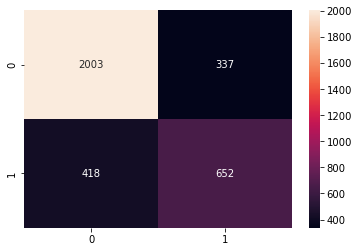

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Confusion matrix: 
 [[2003  337]
 [ 418  652]]

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      2340
           1       0.66      0.61      0.63      1070

    accuracy                           0.78      3410
   macro avg       0.74      0.73      0.74      3410
weighted avg       0.77      0.78      0.78      3410



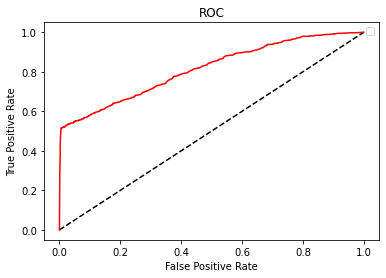

In [53]:
# Run Random Forest with tuning

# Best Score: 0.919022 using {'min_samples_leaf': 1, 'min_samples_split': 3, 'max_depth': 40, 'max_features': 'auto', 'n_estimators': 200}
model_rf = RandomForestClassifier(max_depth=40, n_estimators=200, criterion='gini', min_samples_leaf=1, min_samples_split=3, bootstrap=False, max_features='auto', random_state=random_state)

model_rf.fit(X_train, y_train)

# Predict the output on the test set
y_pred_rf = model_rf.predict(X_test)

# Calculate accuracy
acc_score_rf = round(accuracy_score(y_test, y_pred_rf),4)

# Calculate CV result
cv_result_rf = cross_val_score(model_rf, X_train, y_train, cv=10, scoring='accuracy')

# ROC AUC Score
y_pred_prob_rf = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = round(auc(fpr_rf, tpr_rf), 4)

# Print the model results
print(f'\n ***** Tuned Model: {model_rf} *****')
print(f'\nModel Accuracy: \n{acc_score_rf*100}%')
print(f'\nAverage CV Score: \n{round(np.average(cv_result_rf), 4)}')
print(f'\nROC AUC: \n{round(roc_auc_rf, 4)}')

# Get confusion matrix
cm_model = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

# Get classification report
cr_model = classification_report(y_true=y_test, y_pred=y_pred_rf)

sns.heatmap(cm_model,annot=True,fmt="d")
plt.show()
print('\nConfusion matrix: \n',cm_model)
print('\nClassification report: \n',cr_model)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

## Tuning XGB Classifier hyperparameters

In [ ]:
param_grid = {
    'max_depth': range (3, 10, 1),
    'min_child_weight': range(1,6,2),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma':[i/10.0 for i in range(0,5)]
}

In [1113]:
# XGBoost tuning
model = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state)

param_grid = {
    'max_depth': range (3, 10, 1),
    'n_estimators': range(60, 220, 40),
}

gridsearch_cv(model, param_grid, 10)


/Users/mridul/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mridul/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mridul/opt/anaconda3/envs/pyt

[17:40:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/mridul/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mridul/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mridul/opt/anaconda3/envs/pyt

[17:40:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/mridul/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mridul/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mridul/opt/anaconda3/envs/pyt

[18:30:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 ***** Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None) *****

Best Score: 0.892692 using {'learning_ra

In [1148]:
# XGBoost tuning
# Pass 1: model = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state)
# Pass 2: model = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=9, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state)
# Pass 3: model = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=9, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state)
model = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=9, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state)

# Pass 3
param_grid = {
    'gamma':[i/10.0 for i in range(0,5)]
}

# Pass 2
#param_grid = {
#    'learning_rate': [0.1, 0.01, 0.05],
#    'min_child_weight': [1,2]
#}

# Pass 1
#param_grid = {
#    'max_depth': range (3, 10, 1),
#    'min_child_weight': range(1,6,2)
#}


gridsearch_cv(model, param_grid, 10)


[16:16:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 ***** Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1, seed=42, subsample=0.8,
              tree_method=None, validate_parameters=None, verbosity=None) *****

Best Score: 0.915114 using {'gamma

## Tuned Models - Random Forest

## Tuned Model - XGB Classifier

[18:52:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



 ***** Tuned Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None) *****

Model Accuracy: 
80.42%

Average CV Score: 
0.8344

ROC Score: 
0.8545


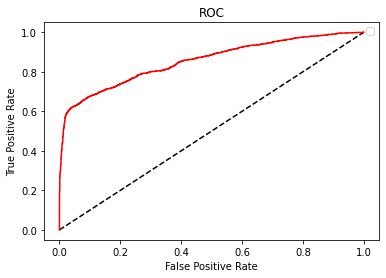

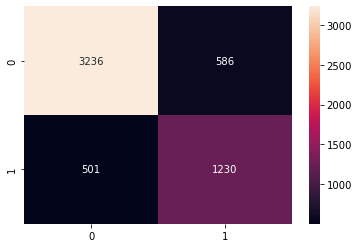


Confusion matrix: 
 [[3236  586]
 [ 501 1230]]

Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3822
           1       0.68      0.71      0.69      1731

    accuracy                           0.80      5553
   macro avg       0.77      0.78      0.77      5553
weighted avg       0.81      0.80      0.81      5553



In [1223]:
## XGBoost with tuning
#Best Score: 0.915114 using {'gamma': 0.0, 'min_child_weight':1, 'max_depth':9, 'learning_rate':0.1}
model_xgb = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=9, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state)

model_xgb.fit(X_train, y_train)

# Predict the output on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Calculate accuracy
acc_score_xgb = round(accuracy_score(y_test, y_pred_xgb),4)

# Calculate CV result
cv_result_xgb = cross_val_score(model_xgb, X_train, y_train, cv=10, scoring='accuracy')

# Print the model results
print(f'\n ***** Tuned Model: {model_xgb} *****')
print(f'\nModel Accuracy: \n{acc_score_xgb*100}%')
print(f'\nAverage CV Score: \n{round(np.average(cv_result_xgb), 4)}')

y_pred_prob_xgb = model_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = round(auc(fpr_xgb, tpr_xgb), 4)
print(f'\nROC Score: \n{roc_auc_xgb}')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

# Get confusion matrix
cm_model = confusion_matrix(y_true=y_test, y_pred=y_pred_xgb)

# Get classification report
cr_model = classification_report(y_true=y_test, y_pred=y_pred_xgb)

sns.heatmap(cm_model,annot=True,fmt="d")
plt.show()
print('\nConfusion matrix: \n',cm_model)
print('\nClassification report: \n',cr_model)

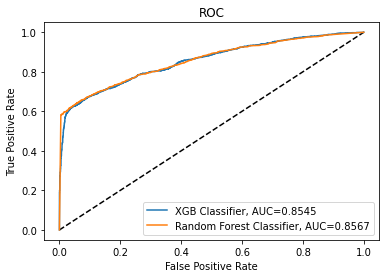

In [1232]:

y_pred_prob_xgb = model_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_prob_xgb)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, label="XGB Classifier, AUC="+str(roc_auc_xgb))
plt.plot(fpr_rf, tpr_rf, label="Random Forest Classifier, AUC="+str(roc_auc_rf))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

## Feature Importance

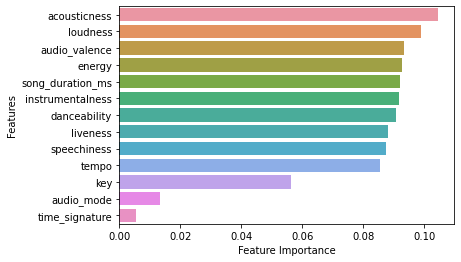

In [1234]:
model_name = "Random Forest"
#model, acc_model, cv_result, y_pred = create_model(model_name)

fi = model_rf.feature_importances_

# CReate a dataframe with 2 arrays
df_features = pd.DataFrame({
    'feature_name': X_train.columns,
    'importance': model_rf.feature_importances_
})
df_features = df_features.sort_values(by=['importance'], ascending=False)
df_features.head()

sns.barplot(x='importance', y='feature_name', data=df_features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()